In [12]:
import numpy as np
import matplotlib.pyplot as plt

import skimage as sk

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import random


# Create Dummy CSD

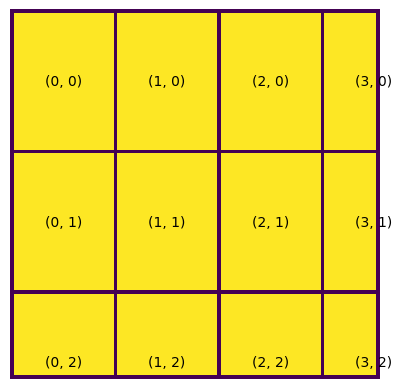

In [10]:

# Create a blank image with a grid of 100x100
grid_size = 100
image = np.ones((grid_size, grid_size), dtype=np.uint8) * 255

horizontal_spacing = np.random.randint(20,30)
vertical_spacing = np.random.randint(20,40)

image[:, 0] = 0
image[:, -1] = 0
image[0, :] = 0
image[-1, :] = 0
image[:,horizontal_spacing::horizontal_spacing] = 0
image[vertical_spacing::vertical_spacing, :] = 0

# Label each block accordingly
for i in range(0, grid_size, vertical_spacing):
    for j in range(0, grid_size, horizontal_spacing):
        x_label = j // horizontal_spacing
        y_label = i // vertical_spacing
        label = f"({x_label}, {y_label})"
        plt.text(j + horizontal_spacing//2, i + vertical_spacing//2, label, color='black',
                 ha='center', va='center')

# Display the resulting image
plt.imshow(image)
plt.axis('off')
plt.show()


# Break into Polygons

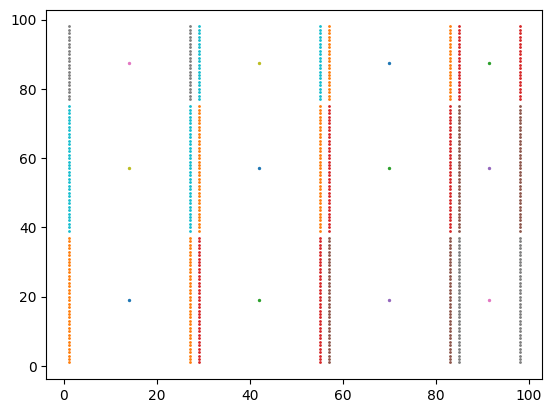

In [11]:
image_labelled = sk.measure.label(image, connectivity=1)

image_regions = sk.measure.regionprops(image_labelled)

for index in range(len(image_regions)):
    region_info = {}

    region_coords = image_regions[index].coords

    # Get boundaries of coordiantes
    temp = {}
    for row in region_coords:
        key = row[0]
        value = row[1]
        if key not in temp:
            temp[key] = [value, value]  # Initialize with the current value
        else:
            temp[key][0] = min(temp[key][0], value)  # Update minimum value
            temp[key][1] = max(temp[key][1], value)  # Update maximum value
    region_coords = np.array([[key, minmax[0]] for key, minmax in temp.items()] + [[key, minmax[1]] for key, minmax in temp.items()])

    y,x = region_coords.T

    px = x.tolist()
    py = y.tolist()

    def flip_coordinates_horizontal_axis(x_coordinates, y_coordinates, axis):
        flipped_x_coordinates = []
        flipped_y_coordinates = []
        
        for x, y in zip(x_coordinates, y_coordinates):
            distance = (axis - y)
            y_flipped = axis + distance
            flipped_x_coordinates.append(x)
            flipped_y_coordinates.append(y_flipped)
        
        return flipped_x_coordinates, flipped_y_coordinates

    def find_polygon_centroid(coordinates):

        n = len(coordinates)
        
        # Calculate the signed area of the polygon
        signed_area = 0
        for i in range(n):
            x_i, y_i = coordinates[i]
            x_j, y_j = coordinates[(i + 1) % n]
            signed_area += (x_i * y_j - x_j * y_i)
        signed_area *= 0.5
        
        # Calculate the coordinates of the centroid
        centroid_x = 0
        centroid_y = 0
        for i in range(n):
            x_i, y_i = coordinates[i]
            x_j, y_j = coordinates[(i + 1) % n]
            factor = x_i * y_j - x_j * y_i
            centroid_x += (x_i + x_j) * factor
            centroid_y += (y_i + y_j) * factor
        centroid_x /= (6 * signed_area)
        centroid_y /= (6 * signed_area)
        
        return centroid_x, centroid_y

    def organize_array_clockwise(arr):
            
        # Calculate the centroid of the points
        centroid = np.mean(arr, axis=0)

        # Calculate the angle of each point with respect to the centroid
        angles = np.arctan2(arr[:, 1] - centroid[1], arr[:, 0] - centroid[0])

        # Sort the points based on the angles in clockwise order
        indices = np.argsort(angles)
        sorted_arr = arr[indices]

        return sorted_arr      

    poly = [(x, y) for x, y in zip(px, py)]
    poly = np.array([p for x in poly for p in x]).reshape(-1,2)
    
    poly_clockwise = organize_array_clockwise(poly)
    x0, y0 = find_polygon_centroid(poly_clockwise)
    x0_, y0_ = flip_coordinates_horizontal_axis([x0], [y0], axis=image.shape[0]/2)
    x0_, y0_ = flip_coordinates_horizontal_axis(y0_, x0_, axis=image.shape[1]/2)
    x0_val, y0_val = x0_[0], y0_[0]

    plt.scatter([x0],[y0], s=2)
    plt.scatter(px,py, s=1)

In [48]:
def generate_dataset(sequence_length):

    ones_count = 1
    max_num = 2 ** (sequence_length)
    rand_num = np.random.randint(1, max_num)

    binary_list = [int(bit) for bit in bin(rand_num)[2:]]

    label = [0] * len(binary_list)
    for i in range(len(binary_list)):
        if binary_list[i] == 1:
            label[i] = ones_count
            ones_count += 1
        
    return binary_list, label
    

[]


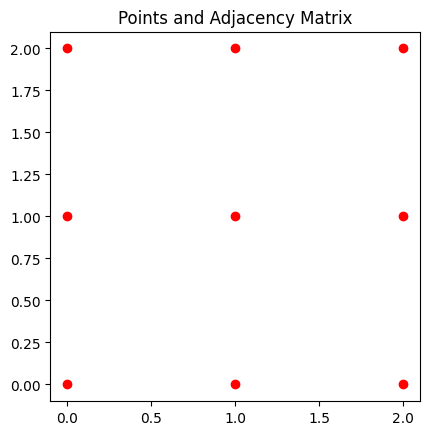

In [148]:
import numpy as np
points = np.array([[0, 0],  [1, 0], [2,0], [0, 1], [1, 1], [2,1], [0,2],[1,2], [2,2]])
from scipy.spatial import Delaunay
# Perform Delaunay triangulation
tri = Delaunay(points)

# Get the simplices of the triangular mesh
triangles = tri.simplices

# Create an empty list to store the convex hull quadrilaterals
convex_hull_quads = []

# Iterate through each triangle and its neighbors
for triangle_idx, neighbors in zip(triangles, tri.neighbors):
    for neighbor_idx in neighbors:
        # Skip if neighbor is -1 (indicating no neighbor)
        if neighbor_idx == -1:
            continue

        # Find the shared edge between the triangle and its neighbor
        shared_edge = list(set(triangle_idx) & set(triangles[neighbor_idx]))

        # Determine the remaining two vertices of the quadrilateral
        unique_vertices = list(set(triangle_idx) ^ set(triangles[neighbor_idx]))

        # Create the convex hull quadrilateral
        list1 = shared_edge
        list2 = unique_vertices
        stitched_list = [x for pair in zip(list1, list2) for x in pair]
        # print(stitched_list)
        if max(stitched_list) - min(stitched_list) > 3:
            pass
        else:
            convex_hull_quads.append(stitched_list) 

# Convert the list of convex hull quadrilaterals to a NumPy array
quads = np.array(convex_hull_quads)
print(quads)
# quads = [[0, 1, 2, 3, 0]]
# Create the adjacency matrix
num_vertices = points.shape[0]
adjacency_matrix = np.zeros((num_vertices, num_vertices), dtype=int)
for quad in quads:
    for i in range(4):
        adjacency_matrix[quad[i], quad[(i+1) % 4]] = 1
        adjacency_matrix[quad[(i+1) % 4], quad[i]] = 1

import matplotlib.pyplot as plt
# Plot the points and lines
fig, ax = plt.subplots()
ax.plot(points[:, 0], points[:, 1], 'ro')

for i in range(num_vertices):
    for j in range(i + 1, num_vertices):
        if adjacency_matrix[i, j] == 1:
            ax.plot([points[i, 0], points[j, 0]], [points[i, 1], points[j, 1]], 'b-')

ax.set_aspect('equal')
ax.set_title('Points and Adjacency Matrix')

plt.show()